# Folded Electro-Optic Modulators on TFLN: Analysis

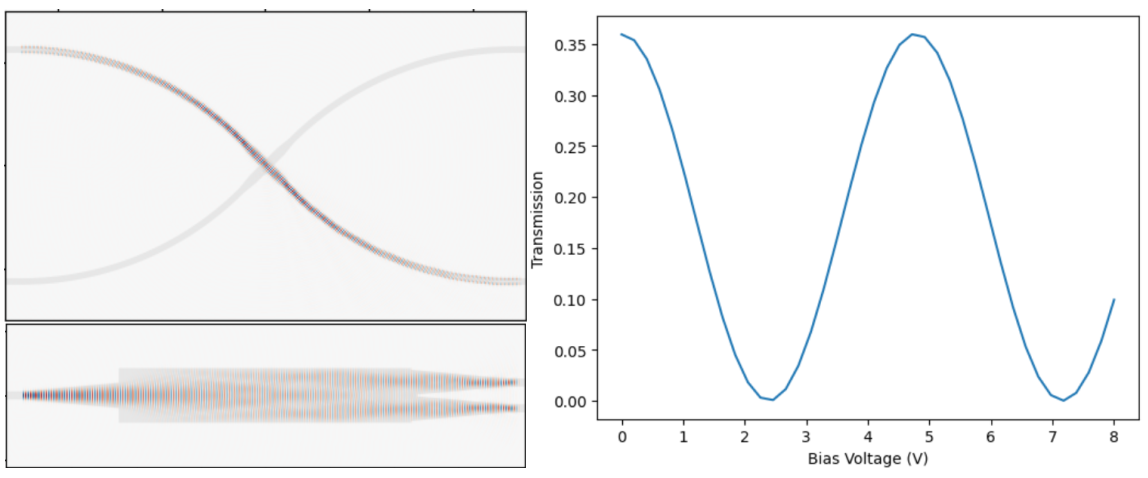

This notebook focuses on analyzing the performance characteristics of the folded electro-optic modulator designed in the [Folded_Modulator_Layout.ipynb](../examples/Folded_Modulator_Layout.rst) notebook.

Our main goals in this notebook are to:
1.  **Analyze RF Properties:** We will investigate the characteristics of the CPW transmission line, specifically its impedance and RF effective index, to ensure proper high-frequency operation.
2.  **Analyze Optical Waveguide Properties:** We will examine the properties of the lithium niobate optical waveguides used in the MZI arms.
3.  **Calculate $V_\pi L$:** We aim to determine the voltage-length product ($V_\pi L$), a key figure of merit indicating the modulator's efficiency.
4.  **Total Device Performance:** We show how such a large device can be efficiently simulated using a circuit model. Each component is automatically simulated with PhotonForge based on the associated model, and then they will be combined into a circuit model analysis to characterize the whole device.

**References**
1. Della Torre, Alberto, *et al*. "Folded electro-optical modulators operating at CMOS voltage level in a thin-film lithium niobate foundry process." *Optics Express* 33.4 (2025): 6747-6757, doi: [10.1364/OE.548003](https://doi.org/10.1364/OE.548003).


Starting live viewer at http://localhost:5001


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


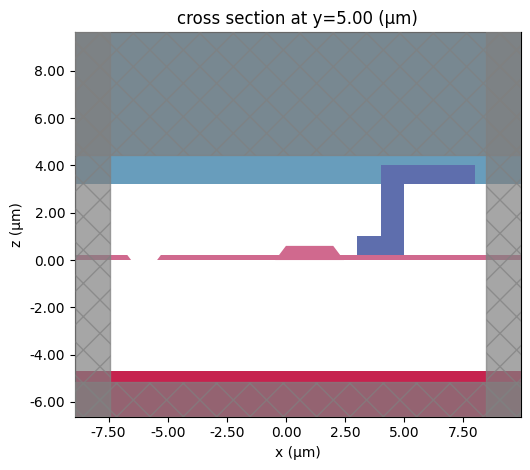

12:28:55 -03 WARNING: ℹ️ ⚠️ RF simulations are subject to new license requirements
             in the future. You have instantiated at least one RF-specific      
             component.                                                         

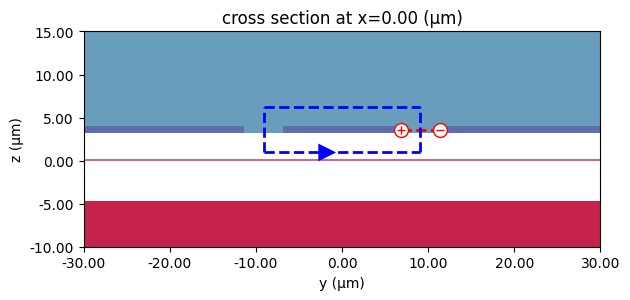

In [1]:
# Execute the layout notebook to define components, technology, and parameters.
%run Folded_Modulator_Layout.ipynb

# Alternatively you can strat by loading the phf file at the end of the previous notebook
# import luxtelligence_lnoi400_forge as lxt
# import numpy as np
# import photonforge as pf
# import tidy3d as td
# import matplotlib.pyplot as plt
# from photonforge.live_viewer import LiveViewer

# pf.load_phf("FOLDED-MODULATOR.phf")


# Define the central operating wavelength (in micrometers).
lambda_0 = 1.55

# Set the default mesh refinement factor for Tidy3D simulations.
pf.config.default_mesh_refinement = 12.0

# Define a range of wavelengths around lambda_0 for analysis.
wavelengths = np.linspace(1.53, 1.57, 51)

### MZI Cross-Section Specification for RF Analysis

To analyze the RF properties (like impedance) of the modulator's active region, we first need a precise definition of its cross-section. In the MZI arms, the optical waveguides run within the gaps between the CPW signal and ground electrodes.

We define this specific cross-section (`mzi_spec`) using the following steps:
1.  Calculate the `mzi_offset` from the center line to the middle of the CPW gap where the waveguides reside.
2.  Retrieve the standard optical waveguide specification (`wg_spec`, "RWG800") from our technology configuration.
3.  Use the [combined_with()](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.combined_with) method, starting with the standard CPW port specification (`cpw_port`). We add the `wg_spec` twice: once at `+mzi_offset` and once at `-mzi_offset`. This creates the combined specification representing the CPW line with the two optical waveguides embedded in the gaps.


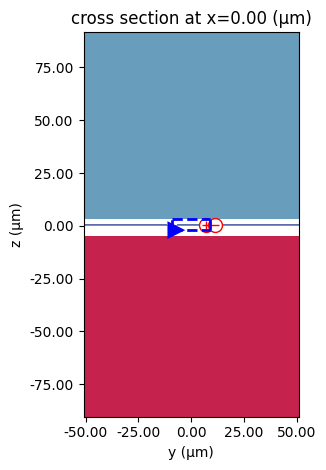

In [2]:
# Calculate the offset for placing waveguides in the middle of the CPW gaps
mzi_offset = signal_width / 2 + gap_width / 2
# Get the optical waveguide port specification ("RWG800")
wg_spec = pf.config.default_technology.ports["RWG800"]
# Create the combined MZI cross-section spec: CPW + two offset waveguides
mzi_spec = cpw_port.combined_with(wg_spec, mzi_offset).combined_with(
    wg_spec, -mzi_offset
)

# Create a Tidy3D impedance calculator instance based on the MZI cross-section
ic = mzi_spec.to_tidy3d_impedance_calculator()
# Plot the MZI cross-section geometry
ax = pf.tidy3d_plot(mzi_spec)
# Plot the voltage integration path on the cross-section
_ = ic.voltage_integral.plot(ax=ax, x=0)
# Plot the current integration path on the cross-section
_ = ic.current_integral.plot(ax=ax, x=0)

### RF Impedance and Effective Index

We proceed with the RF analysis by calculating the characteristic impedance (Z₀) and the RF effective index (n_eff) of the MZI section (`mzi_spec`) over our defined frequency range. We set a quite high mesh refinement level and run the `pf.port_modes` simulation, requesting both impedance and group index.

After the simulation completes, we extract the results. To visualize them effectively, we create a figure with two subplots arranged side-by-side:
1.  **Left Plot:** Shows the simulated real part of the characteristic impedance (Z₀) versus frequency (solid line).
2.  **Right Plot:** Shows the calculated RF effective index (n_eff) versus frequency.

Estimated measurement and simulation data points [1] are also overlaid for visual comparison. 

We analyze two key aspects:
* **Impedance Matching:** The RF impedance should ideally be close to 50 Ohms to minimize reflections when connecting to standard RF equipment. The simulation results, compared with the measurement markers on the left plot, indicate how well this condition is met across the target bandwidth.
* **Velocity Matching:** For maximum efficiency, the phase velocity of the RF signal (related to the RF effective index) should match the group velocity of the optical signal within the waveguide. This ensures that as the optical signal propagates, the electric field applied via the RF electrodes produces a cumulative, constructive phase shift through the electro-optic effect.


12:28:56 -03 WARNING:  ℹ️ ⚠️ RF simulations are subject to new license            
             requirements in the future. You are using RF-specific components in
             this simulation.                                                   
              - Contains a 'LossyMetalMedium'.                                  

Loading cached simulation from .tidy3d/pf_cache/GXO/ms_info-FNGXZOY35GNEFHCBLDW7LXAQVG5H2VCXRF6X6EYAXPEKIZO2VMBQ.json.


Progress: 100%


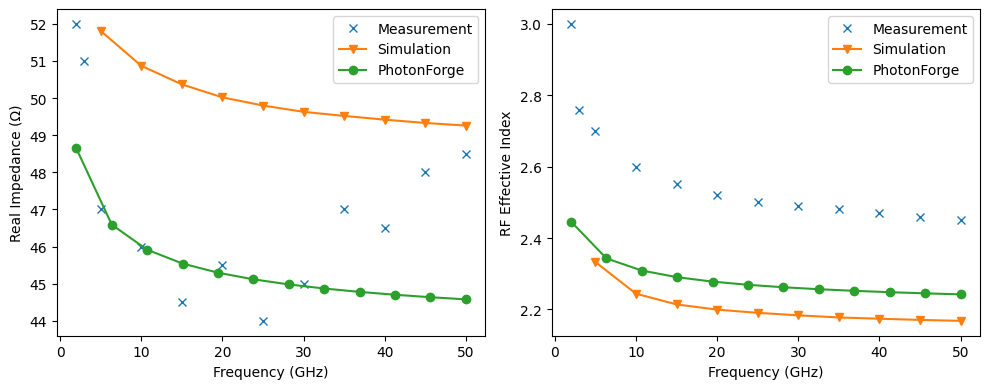

In [3]:
# Define the RF frequency range for analysis
freqs_rf = np.linspace(2, 50, 12) * 1e9

# Calculate RF modes, impedance (z0), and group index for the MZI cross-section
mode_solver_rf, z0 = pf.port_modes(
    mzi_spec, freqs_rf, mesh_refinement=30, impedance=True, group_index=True
)
n_eff_rf = mode_solver_rf.data.n_eff

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# The estimated measurement data points (Length = 0.99 cm)
f_measured = [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
z_measured = [52, 51, 47.0, 46.0, 44.5, 45.5, 44.0, 45.0, 47.0, 46.5, 48.0, 48.5]
n_eff_measured = [3.0, 2.76, 2.7, 2.60, 2.55, 2.52, 2.50, 2.49, 2.48, 2.47, 2.46, 2.45]

f_sim = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_eff_sim = [2.3327, 2.2441, 2.2140, 2.1994, 2.1904, 2.1834, 2.1775, 2.1739, 2.1706, 2.1679]
z_sim = [51.81, 50.87, 50.37, 50.02, 49.80, 49.63, 49.52, 49.42, 49.33, 49.26]

# Plot Real Impedance on the left subplot (axes[0])
axes[0].plot(f_measured, z_measured, "x", label="Measurement")
axes[0].plot(f_sim, z_sim, "v-", label="Simulation")
axes[0].plot(freqs_rf / 1e9, z0.isel(mode_index=0).real, "o-", label="PhotonForge")
axes[0].set_xlabel("Frequency (GHz)")
axes[0].set_ylabel("Real Impedance (Ω)")
axes[0].legend()


# Plot RF Effective Index on the right subplot (axes[1])
axes[1].plot(f_measured, n_eff_measured, "x", label="Measurement") 
axes[1].plot(f_sim, n_eff_sim, "v-", label="Simulation")
axes[1].plot(freqs_rf / 1e9,n_eff_rf.isel(mode_index=0), "o-",label="PhotonForge")
axes[1].set_xlabel("Frequency (GHz)")
axes[1].set_ylabel("RF Effective Index")
axes[1].legend()

plt.show()

**Sources of Mismatch**

The small discrepancy observed between the measured and simulated data may stem from **fabrication inaccuracies** [1]. Furthermore, variations in simulation results could arise from minor differences in simulation setups, such as mesh refinement or the dimensions (width and height) of the simulation region.

**Optical Group Index**

To assess the velocity matching condition, we need to compare the RF effective index (calculated previously) with the group index of the *optical* signal propagating in the waveguide within the MZI arms.

Here, we calculate the optical group index for the standard ridge waveguide ("RWG800") used in our design:
1.  We define the optical frequency (`freqs`) corresponding to our operating wavelength (`lambda_0` = 1.55 µm).
2.  We run the `pf.port_modes` solver specifically for the "RWG800" waveguide specification at this optical frequency, ensuring we request the group index calculation (`group_index=True`).

We can then compare this optical group index value to the range of RF effective index values plotted previously. A close match indicates good velocity matching between the RF drive signal and the optical wave, which is crucial for efficient modulation.

12:28:57 -03 WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/6SS/ms_info-YINFK5DOLQLEPPYSFHE5OWFF5RTHHJ37ZIGVDAJGC62A334VSF3A.json.


Progress: 100%


             WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

wavelength    n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                 
1.934145e+14 0                 1.55  1.89438    0.0          0.992161   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.947355        0.899808   0.772373   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              2.278834               -98.736107

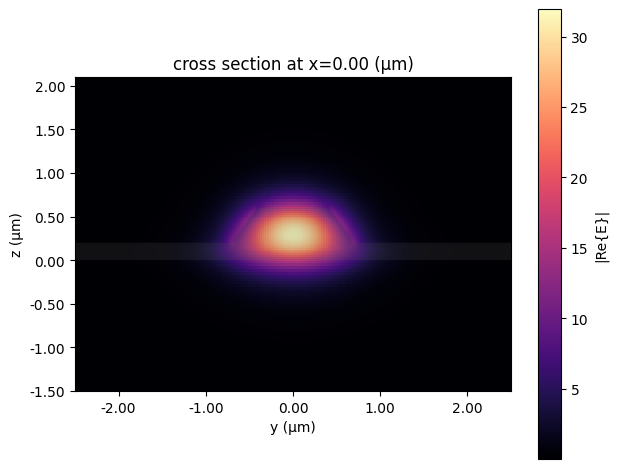

In [4]:
# Define the optical frequency based on the operating wavelength (lambda_0 = 1.55um)
freqs = [pf.C_0 / lambda_0]

# Calculate optical modes for the standard waveguide ("RWG800") at the defined frequency
mode_solver = pf.port_modes("RWG800", freqs, mesh_refinement=30, group_index=True)
# Plot the E-field distribution of the fundamental optical mode
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
# Display the simulation results (including effective and group index) as a DataFrame
mode_solver.data.to_dataframe()

### $V_\pi L$ Calculation

Now, we aim to calculate the $V_\pi L$ product for the modulator. $V_\pi L$ is a crucial figure of merit representing the modulator's efficiency; it's the product of the voltage required to achieve a $\pi$ phase shift ($V_\pi$) and the effective interaction length ($L$) over which the RF field interacts with the optical mode. A lower $V_\pi L$ indicates higher efficiency (less voltage needed for the same phase shift over a given length).

The first step towards calculating $V_\pi L$ is determining how much effective electric field interacts with the optical mode per unit volt applied to the RF electrodes. Since we are using X-cut Lithium Niobate (LiNbO₃) [1], the dominant electro-optic coefficient (r₃₃) couples to the electric field component perpendicular to the device surface (Ey in this coordinate system, aligned with the crystal's z-axis).

Therefore, we perform the following:
1.  Calculate the voltage (`v0`) between the CPW electrodes corresponding to the simulated RF mode power using the pre-defined voltage integral path.
2.  Normalize the simulated Ey field component (`mode_solver_rf.data.Ey`) by this voltage `v0`. This gives us the Ey field strength per volt applied. We select the field for the fundamental RF mode at the first simulated frequency.
3.  Adjust the y-coordinates of this normalized field (`ey_norm`) by subtracting the `mzi_offset` to center the view relative to one of the optical waveguides within the gap.
4.  Visualize the absolute value of this normalized Ey field distribution (`ey_norm`) in the cross-section (at x=0) where the optical waveguide sits. This confirms the field profile interact with the optical waveguide.

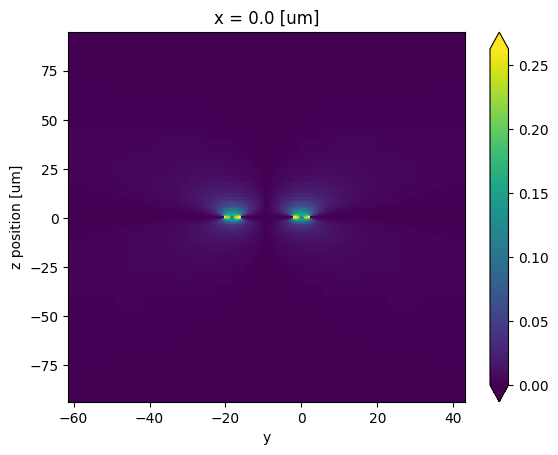

In [5]:
# Calculate the voltage associated with the simulated RF mode using the defined integral path
v0 = ic.voltage_integral.compute_voltage(mode_solver_rf.data)

# Calculate the normalized Ey field (Ey per unit volt)
ey_norm = (mode_solver_rf.data.Ey / v0).isel(f=0, mode_index=0, drop=True).abs
# Shift y-coordinates to center relative to the optical waveguide position
ey_norm = ey_norm.assign_coords(y=ey_norm.y - mzi_offset)

# Plot the normalized Ey field distribution in the cross-section (x=0)
ey_norm.isel(x=0).transpose("z", "y").plot(robust=True)

**Calculating the Electro-Optic Index Change (Δn)**

Having calculated the normalized electric field (Ey per unit volt) relevant for modulation in the previous step, we now use this field to determine the resulting change in the refractive index (Δn) of the lithium niobate waveguide via the Pockels electro-optic effect. This Δn is the change induced *per volt* applied to the RF electrodes.

1.  We retrieve the material properties for Lithium Niobate (`ln`) from the material library at our operating wavelength (`lambda_0`). Specifically, we calculate the extraordinary refractive index (`n_e`), as this corresponds to the light polarization interacting with the dominant `r33` electro-optic coefficient in our X-cut orientation.
2.  We define the value for the `r33` electro-optic coefficient.
3.  We apply the Pockels effect formula ($\Delta n = -0.5 n_e^3 r_{33} * E_\text{applied}$) using the normalized Ey field (`ey_norm`) as our $E_\text{applied}$ (per unit volt). This gives us the spatial distribution of the refractive index change per volt.
5.  Finally, we visualize this induced index change (`Δn`) distribution in the device cross-section. Although the calculation domain might be larger, this change physically occurs only within the lithium niobate material itself. This visualization helps understand where the strongest index change occurs.

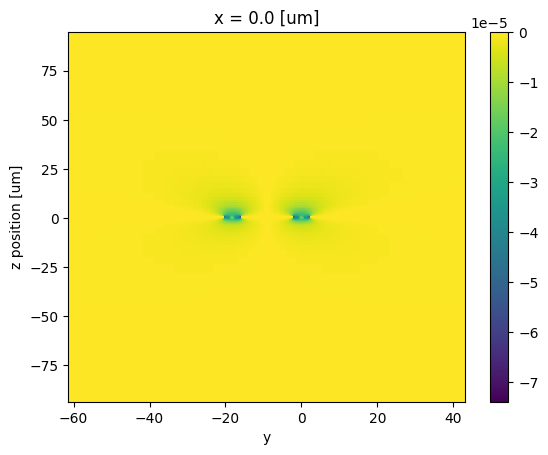

In [6]:
# Get Lithium Niobate material properties from library (Zelmon1997 model), specify optical axis
ln = td.material_library["LiNbO3"]["Zelmon1997"](optical_axis=1)
# Extract ordinary (eps_o) and extraordinary (eps_e) permittivity at the optical frequency
eps_o, eps_e, _ = (e.real for e in ln.eps_diagonal(pf.C_0 / lambda_0))

# Calculate the extraordinary refractive index
n_e = eps_e**0.5
# Define the r33 electro-optic coefficient (units: µm/V)
r33 = 30.9e-6

# Calculate the change in refractive index (Δn) per unit volt using the Pockels effect formula
Δn = -0.5 * n_e**3 * r33 * ey_norm

# Plot the calculated Δn distribution in the cross-section (x=0)
# Note: This change only applies within the LiNbO3 material regions
_ = Δn.isel(x=0).transpose("z", "y").plot(robust=False)

**Defining a Function for Voltage-Perturbed Optical Simulation**

To calculate $V_\pi L$, we need to determine how the optical mode's effective index changes as a function of the applied voltage. To facilitate this, we define a function `perturbed_solver(voltage)`.

This function takes a specific `voltage` value as input and performs the following steps:
1.  Creates a custom anisotropic material definition (`perturbed_ln`) representing Lithium Niobate where the permittivity tensor incorporates the electro-optic effect. The component corresponding to the extraordinary axis (`yy` in this case) is modified based on the refractive index change `Δn` (calculated per unit volt previously) scaled by the input `voltage`. Other components use the standard ordinary permittivity of Lithium Niobate.
2.  Calls the optical mode solver (`pf.port_modes`) for our standard waveguide specification (`wg_spec`) at the operating frequency. Crucially, it passes the custom technology definition `custom_tfln_pdk` where the standard LiNbO3 material is *replaced* by our voltage-dependent `perturbed_ln`.
3.  Returns the mode solver results for the specified applied `voltage`.

By calling this function with different voltages (e.g., 0V and 1V), we can find the change in the optical mode's effective index per volt, which is the next step towards calculating $V_\pi L$.

In [7]:
# Create a spatially uniform DataArray for the ordinary permittivity (used for xx, zz components)
eps_o_array = td.SpatialDataArray(
    np.full((1, 1, 1), eps_o), coords={"x": [0], "y": [0], "z": [0]}
)


# Define a function to run the optical mode solver with voltage-perturbed LiNbO3
def perturbed_solver(voltage):
    # Create a custom anisotropic medium definition for LiNbO3 including the EO effect
    perturbed_ln = td.CustomAnisotropicMedium(
        # xx component uses ordinary permittivity
        xx=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
        # yy component includes n_e perturbed by voltage * Δn (per volt)
        yy=td.CustomMedium(permittivity=(n_e + voltage * Δn) ** 2, subpixel=True),
        # zz component uses ordinary permittivity
        zz=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
    )
    # Run the mode solver for the waveguide spec at the optical frequency
    # Use a custom technology where LiNbO3 is replaced by the perturbed version
    return pf.port_modes(
        wg_spec, [pf.C_0 / lambda_0], technology=custom_tfln_pdk(ln=perturbed_ln)
    )

**Calculating $V_\pi L$**

Using the `perturbed_solver` function defined previously, we can now calculate the change in the optical effective index (`n_eff`) as a function of applied voltage and ultimately determine the $V_\pi L$ product.

1.  We define an array of `voltages` (0V to 4V) over which to run the simulation.
2.  We loop through these voltages, calling `perturbed_solver` for each one and extracting the calculated `n_eff` for the fundamental optical mode.
3.  We plot `delta_n_eff` versus `voltage` to visualize the relationship. As expected, the variation is quite linear.
4.  Assuming linearity, we calculate the slope `dneff_dv` (change in effective index per volt) using the first and last points of our simulation data.
5.  We apply the standard formula $V_{pi}L = \frac{\lambda_0}{2}/|\frac{d_{neff}}{dv}|$ to calculate the `vpil` product in units of V·cm.
8.  We also include the penalty for impedance mismatch and voltage scaling.
9.  Finally, we print the result, converting the units to the more common V·cm. 

As noted, the calculated value can be compared to the experimental results reported in reference [1] (2.5-2.7 V·cm for push-pull drive), and we observe excellent agreement between our simulation and the experiment.

12:28:58 -03 WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/3PY/ms_info-47IUNAY72LVUOQGX7Y4ICM2R55AEDMGQJZ635QUH365QRUD545WA.json.


Progress: 100%


             WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/2BL/ms_info-5WOGIJ4QLE7OE3TGBWHMGWOORNVVPCQSQWWFMVUDQ6IR5ZC34UJQ.json.


Progress: 100%


             WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/TGD/ms_info-RWZJYZPBJGR2M6Y26KXLKZ7MSRQ7TKEW54AJEHWDJ57WOK7IPXSQ.json.


Progress: 100%


             WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/QZ4/ms_info-I6F7O47Q7KSUGFB3ZD4LS4QV2KB67IUQXORBGL36RDBZ4RSHMIIQ.json.


Progress: 100%


12:28:59 -03 WARNING: 'simulation.structures[0]' is outside of the simulation   
             domain.                                                            

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/J26/ms_info-W36YWT62OGCLJZMSJV2KOZ43QREX4E5IRRVCBSGRXSNZTFYYV3MQ.json.


Progress: 100%


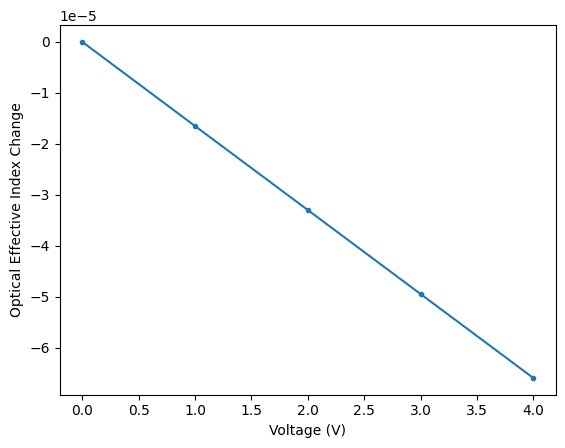

Vπ·L (single-drive) = 5.13 V·cm
Vπ·L (push-pull)    = 2.57 V·cm


In [8]:
# Define the range of voltages for the sweep
voltages = np.arange(5)

# Calculate optical n_eff for each voltage using the perturbed_solver function
n_eff = [
    perturbed_solver(v).data.n_eff.isel(mode_index=0, f=0).item() for v in voltages
]

# Calculate and plot optical effective index change vs applied voltage
delta_n_eff = np.array(n_eff) - n_eff[0]
_ = plt.plot(voltages, delta_n_eff, ".-")
plt.gca().set(xlabel="Voltage (V)", ylabel="Optical Effective Index Change")
plt.show()

# Calculate the change in n_eff per volt (dneff/dV) using the first and last points
dneff_dv = abs(n_eff[-1] - n_eff[0]) / (voltages[-1] - voltages[0])

# Calculate V_pi*L using the formula: Vπ·L = λ₀ / (2 * |dn_eff/dV|)
vpil = 0.5 * lambda_0 / dneff_dv  # Result in V·μm

z_load = 50  # Ω
z0_low_freq = 60  # According to measurements

# The penalty for impedance mismatch and voltage scaling
vpil_mismatch = vpil * (2 * z0_low_freq) / (z0_low_freq + z_load)


# Print Vπ·L in V·cm for single-drive configuration
print(f"Vπ·L (single-drive) = {vpil_mismatch * 1e-4:.2f} V·cm")
# Print Vπ·L in V·cm for push-pull configuration (typically half of single-drive)
print(f"Vπ·L (push-pull)    = {vpil_mismatch * 1e-4 / 2:.2f} V·cm")

**Optional: MMI Performance Verification**

To analyze the performance of the standalone 1x2 MMI splitter component (`mmi`) designed earlier, we calculate its scattering matrix (S-matrix). The `mmi.s_matrix()` method is called, simulating the component over the optical `wavelengths` range previously defined. The resulting S-parameters, characterizing transmission and reflection properties, are then plotted using the `pf.plot_s_matrix` helper function.

Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-LYQ66VYNV7L5J4OQKKBICZTNEIG5S45QUGHXN3S2HS4IR6WEVV7Q.json.


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-LKKI5MMCYQ2EATD4UPUYTKSMIDYKMC4MTG53RBMUBYBYGSD767KQ.json.


Progress: 100% 


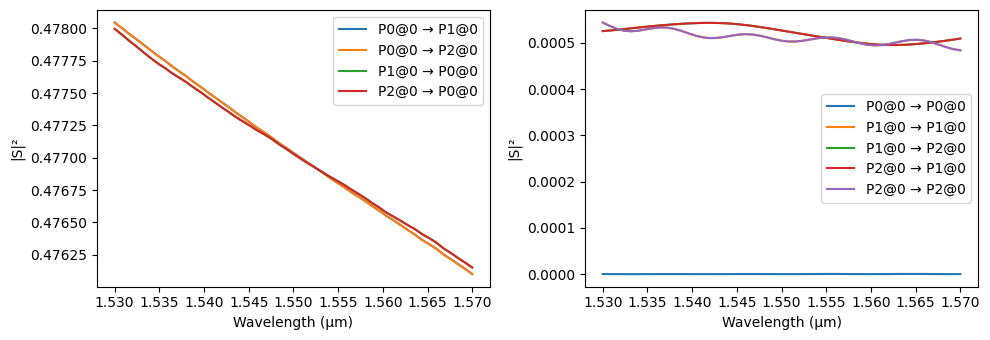

In [9]:
# Calculate the S-matrix for the MMI component over the specified wavelengths
s_matrix_mmi = mmi.s_matrix(frequencies=pf.C_0 / wavelengths)
# Plot the calculated S-parameters (transmission/reflection) vs wavelength
_ = pf.plot_s_matrix(s_matrix_mmi)

In order to plot the fields, we can use the [batch_data_for](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.batch_data_for) function from the Tidy3D model to get the [BatchData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.BatchData.html) that includes the fields from our extra monitor:

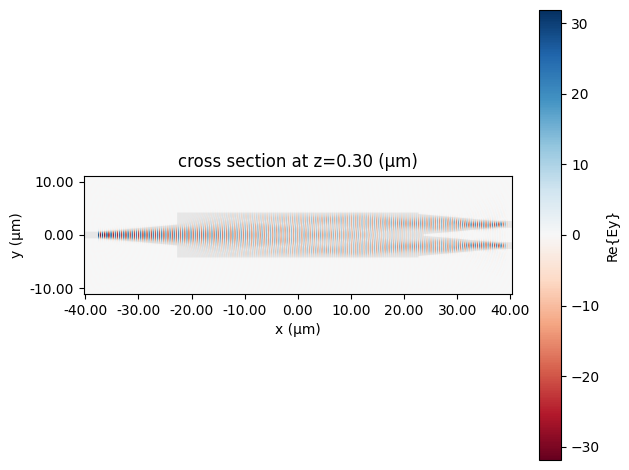

In [10]:
sim_data_mmi = mmi.active_model.batch_data_for(mmi)
_ = sim_data_mmi["P0@0"].plot_field("field", "Ey", robust=False)

Similarly, the performance of the standalone angled crossing component (`crossing`) is analyzed by calculating its S-matrix over the defined optical `wavelengths`. 

Loading cached simulation from .tidy3d/pf_cache/TYR/fdtd_info-X5JEXLY5WNU5KBRXHQADNQEISTVW5G6D3UBJHWEBIVZ3WMQGT37Q.json.


Loading cached simulation from .tidy3d/pf_cache/TYR/fdtd_info-ZAFNFBYR3J6D5IIHN5IOZUVHDYQZMPOZWPHMLQFNMLBSNNGH2NTA.json.


Progress: 100% 


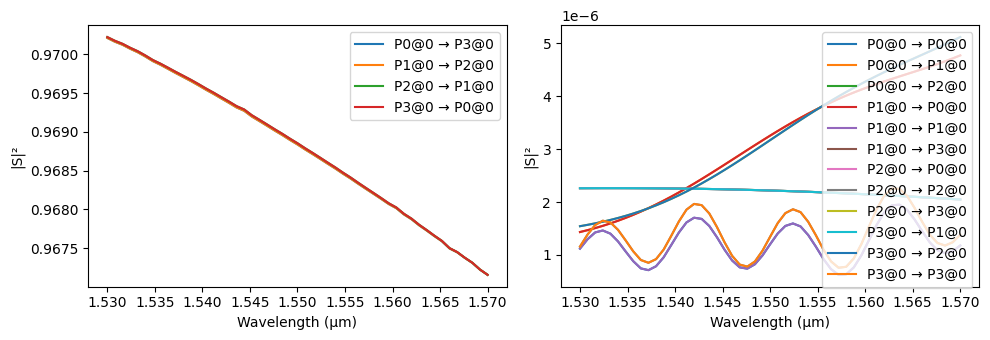

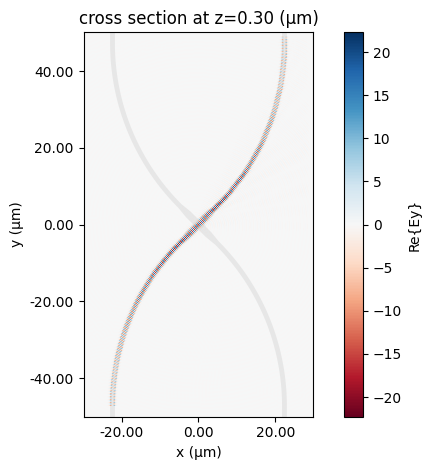

In [11]:
s_matrix_crossing = crossing.s_matrix(frequencies=pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_crossing)
sim_data_crossing = crossing.active_model.batch_data_for(crossing)
_ = sim_data_crossing["P0@0"].plot_field("field", "Ey", robust=False)

### Path Length Calculation

Ensuring phase matching between the Radio Frequency (RF) drive signal and the optical signal is critical for optimal performance in electro-optic modulators like MZIs. In the straight, parallel arms of the MZI, phase matching is often achieved by carefully designing the waveguide's optical group index to match the RF transmission line's effective index, as both signals propagate along the same physical path length.

However, this condition often breaks down in non-straight sections of the circuit, such as bends, tapers, and crossings. In these areas, the physical path length traced by the optical waveguide might differ from the path length of the overlying RF transmission line (e.g., a Coplanar Waveguide - CPW). This discrepancy leads to a phase mismatch that must be compensated for, typically by adjusting the length of the RF path elsewhere (represented by `extra_cpw_path`).

To determine the necessary compensation, we first need to calculate the precise optical path length through these non-straight sections. 

1.  **Crossing Path:** It measures the length of the optical waveguide segment within the `crossing` component using the [.length()](../_autosummary/photonforge.Path.rst#photonforge.Path.length) on the relevant `Path` structure.
2.  **Connecting Routes:** It adds the lengths of the two routes (`route_1_crossing_right` and `route_3_crossing_right`) that connect this crossing to adjacent components. These lengths are obtained using the [.route_length](../_autosummary/photonforge.route_length.rst#photonforge.route_length) function.

The resulting `optical_crossing_length` represents the total distance the optical signal travels through this specific bending and crossing segment, which can then be compared to the corresponding RF path length to calculate the required phase compensation.


In [12]:
# Calculate the total optical path length through the specific bending section.
optical_crossing_length = (
    # Calculate the length of the optical waveguide path within the crossing component.
    # This specifically targets the first structure found on GDS layer (2, 0)
    crossing.get_structures(layer=(2, 0))[0].length()
    # Add the lengths of the two optical waveguide routes that connect the
    # crossing component to other parts of the circuit within this bending section.
    + pf.route_length(route_1_crossing_right)
    + pf.route_length(route_3_crossing_right)
)

# Print the calculated optical path length.
print(f"Optical path length of the bending section: {optical_crossing_length:.1f} um")

Optical path length of the bending section: 563.0 um


Now, we calculate the physical length of the signal line of the RF path within the `cpw_bend` component. 

In [13]:
# Calculate the physical path length of the RF transmission line bend.
rf_bend_length = cpw_bend.get_structures(layer=(21, 1))[0].length()
# Print the calculated length of the RF bend path.
print(f"RF bend path length: {rf_bend_length:.1f} um")

RF bend path length: 382.7 um


We now refine the required RF compensation length (`extra_cpw_path`) by accounting for the difference in RF propagation speed (effective index) between the main transmission line layer ('MET_1') and the layer used for the bends ('MET_2'), also considering the effect of the bend radius itself.

1.  **Bent Effective Index (`n_eff_top`):** We first define a `photonforge.Port` object (`top_cpw_port_bent`) that combines the 'MET_2' CPW specification (`top_cpw_port`) with the calculated RF bend radius (`cpw_bend_radius`). We then calculate the RF effective index for this specific bent geometry using `pf.port_modes`.
2.  **Effective Index Ratio (`n_eff_ratio`):** We calculate the mean ratio of the effective index on 'MET_1' (`n_eff_rf`, from the previous RF simulation) to the effective index on 'MET_2' within the bend (`n_eff_top`). This ratio quantifies the relative difference in RF propagation speed.
3.  **Final Calculation:** The required `extra_cpw_path` *per compensation segment* is determined by scaling the physical path length difference (`optical_crossing_length - rf_bend_length`) by the `n_eff_ratio`. This scaling converts the physical difference into an *equivalent electrical length difference* relative to the main 'MET_1' layer. We divide by two because this compensation length is added in two separate `extra_cpw_path` segments within the layout. The calculated value is then printed.

In [14]:
# Create a Port object representing the bent CPW section on MET_2.
# Including the bend_radius allows the mode solver to account for bend effects.
top_cpw_port_bent = pf.Port(
    center=(0, 0), input_direction=0, spec=top_cpw_port, bend_radius=cpw_bend_radius
)
# Calculate RF modes for this bent MET_2 CPW spec over the RF frequency range.
# Use very high mesh refinement (40) for accuracy.
mode_solver_rf_top = pf.port_modes(top_cpw_port_bent, freqs_rf, mesh_refinement=40)

# Extract the RF effective index for the fundamental mode on the bent MET_2 CPW.
n_eff_top = mode_solver_rf_top.data.n_eff

# Calculate the mean ratio of n_eff on MET_1 (n_eff_rf) to n_eff on bent MET_2 (n_eff_top).
n_eff_ratio = (n_eff_rf.isel(mode_index=0) / n_eff_top.isel(mode_index=0)).mean().item()

# Calculate the physical path length difference between the optical crossing section and the RF bend.
physical_length_difference = (
    optical_crossing_length - rf_bend_length
) # Physical path difference (Optical - RF_MET2_Bend).

# Calculate the required extra CPW path length *per segment* for phase compensation.
# 1. Scale physical length diff by n_eff_ratio to get equivalent electrical length diff relative to MET_1.
# 2. Divide by 2 because the compensation is applied in two separate segments ('cpw_on_met2' instances).
extra_cpw_path = (
    physical_length_difference * n_eff_ratio / 2
) # Required length per segment in um.

# Print the calculated extra CPW path length needed per segment.
print(f"Calculated extra CPW path length needed: {extra_cpw_path:.1f} um")

Loading cached simulation from .tidy3d/pf_cache/AJ3/ms_info-OS7HGE6VUTV3MZ5I74JWPE3XTF3LBER4RKPCSFXNOPKMZBID2XQQ.json.


Progress: 100%


Calculated extra CPW path length needed: 110.4 um


## Optical Circuit Simulation

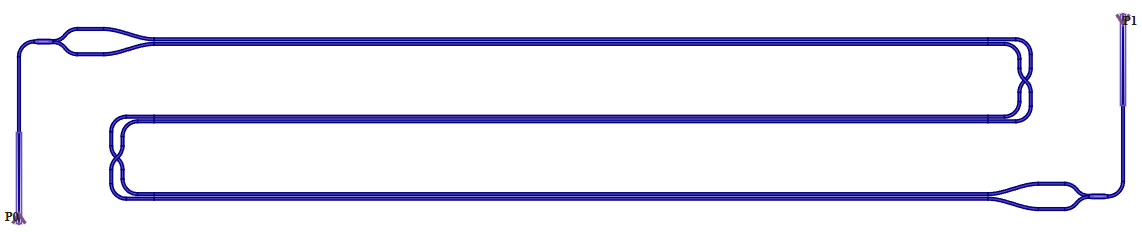


Finally, we perform a circuit simulation of the entire assembled `optical_circuit`. We first set the Tidy3D logging level to "ERROR" to minimize verbose output during the process. Then, with a single command, `optical_circuit.s_matrix()`, PhotonForge orchestrates the analysis over the defined optical `wavelengths`. It automatically invokes the appropriate simulation model associated with each component within the circuit hierarchy. This includes running Tidy3D simulations for elements like MMIs, crossings, and, importantly, the bends and S-bends used in routes (which were configured in the layout notebook to use Tidy3D models due to their non-negligible loss and effects). Analytical models are used for other components like the straight waveguides with their defined electro-optic properties. PhotonForge then combines the S-parameters from all individual component simulations based on the circuit's connectivity to compute the overall S-matrix for the complete modulator. The resulting S-matrix, showing the device's overall transmission and reflection characteristics versus wavelength, is then plotted using `pf.plot_s_matrix`.

Loading cached simulation from .tidy3d/pf_cache/WW7/ms_info-KY3ILI6BFD4RHH54V5DMXFWBKZQMURCMXWT67LV3NENQUIIUUUFQ.json.


Loading cached simulation from .tidy3d/pf_cache/MRD/fdtd_info-O6MP6TJRR2OSSKGKD6VZHJLS6GJ5O3SZV3ZA7ANGQPUHH6JCMFJA.json.


Loading cached simulation from .tidy3d/pf_cache/BPE/ms_info-UGI324JAJHW6JXFDRGL7A6BF5ZNTR7JXUKLUTIJO5CV7WOHG6P4A.json.
Loading cached simulation from .tidy3d/pf_cache/FOL/fdtd_info-OAUBFOVEHJ3BYSRD4JLDAGG6RWPAMP72EPIVE7IGZVVKZXUOUNNA.json.


Loading cached simulation from .tidy3d/pf_cache/55W/ms_info-AZ6F26HV7BQS4OP6CII4EP5MHQ2O2XCXGZFQY6M4Q4UE45N2NV4Q.json.


Loading cached simulation from .tidy3d/pf_cache/OFF/fdtd_info-UZ4G72TJOFUA5PQISZTIQHH2T2FP7RN6IH4FNTO56W7PKPCWTWCA.json.


Loading cached simulation from .tidy3d/pf_cache/CBN/fdtd_info-AYPWJNHXELKPX7VMKBPOOVMWIWZ3ZG2UQHMLYHS5GO4HKZ66DGZA.json.


Loading cached simulation from .tidy3d/pf_cache/CBN/fdtd_info-PU5WIWXU23QRNUIRDWCTAY46PEELDW5PP6YZNKKV4VFVYTCPCMKQ.json.


Loading cached simulation from .tidy3d/pf_cache/DIY/ms_info-GBDAEP3JFSV7WRMJB42NEHKTIP6HQ3ROEON3R67PAZAF53PLELXQ.json.
Loading cached simulation from .tidy3d/pf_cache/DOV/ms_info-BY2IYCW4VSWLSHGXDEESAYLQTJMAA4PBXWUED2YTWRYVMXVENRZA.json.


Loading cached simulation from .tidy3d/pf_cache/GB2/ms_info-NFZO3YOUCBA2N2UKKU7QYNVHSG6LRLNZHEIQGWAR3SVN42RIE6KA.json.
Loading cached simulation from .tidy3d/pf_cache/YJ2/ms_info-YAAYH7TJVXYXXVI3POVIXWK46ZNQIO3KD4ECISY3GLQ64EF5CKWQ.json.


Loading cached simulation from .tidy3d/pf_cache/VUM/fdtd_info-HUJD3GNX546CWEW2MGYFPYELLZQS3RVVBSLJP6IJ6RVJHL7TNIQQ.json.
Loading cached simulation from .tidy3d/pf_cache/VUM/fdtd_info-S2XMIQB5YOT35XLHEBGNB2NJF5VKZ7UXAE4JNYCDANHALTDAW5PA.json.


Loading cached simulation from .tidy3d/pf_cache/67Z/fdtd_info-K7IVONIFPR3HLJRDTSFJAHXR7LWVZNAQ7XGAZLQUPW3JJTF77L6Q.json.
Loading cached simulation from .tidy3d/pf_cache/T52/fdtd_info-TQSAPX2GMNPTJIRQLBUT4ZWSUYPOVEGH5ZINZIUYIMCEQEX4JVIA.json.


Loading cached simulation from .tidy3d/pf_cache/BZ3/fdtd_info-TUGUPNF4SZFMRUXRSNO5QOTNUGEBMHS6UBCUGGDPPCG7AJEHXX6A.json.
Loading cached simulation from .tidy3d/pf_cache/U7L/fdtd_info-DZCP3CH5MWSKE6CJYZESNKC2ABUIU7WS3C43UGOWK7MH32VWBYEA.json.


Loading cached simulation from .tidy3d/pf_cache/T52/fdtd_info-III4YOXBR56PJL6BI457OO4RFHYVRUELJJSISSAXLIIFE2R5V6OQ.json.


Progress: 100% 


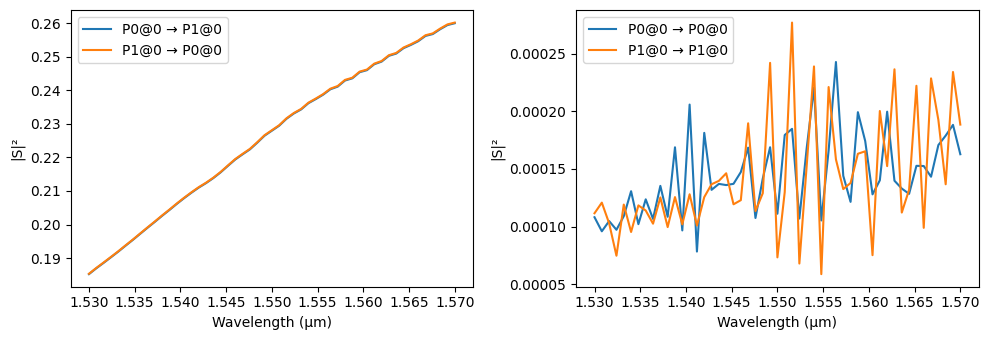

In [15]:
# Set Tidy3D logging level to ERROR to reduce informational messages during simulation runs.
td.config.logging_level = "ERROR"

# Calculate the S-matrix for the complete optical_circuit.
s_matrix_circuit = optical_circuit.s_matrix(frequencies=pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_circuit)

### Modeling Voltage-Dependent Response
To analyze the optical circuit output as a function of applied voltage, we first need a model for the voltage-dependent complex effective index of the active waveguides, including baseline propagation loss. We start by defining an estimated propagation loss value (`loss_db_per_cm`) in units of dB/cm, typically arising from fabrication imperfections. From this, we calculate the corresponding imaginary part (`k`) of the complex effective refractive index ($n_{eff} = n_{real} + ik$) at the operating wavelength `lambda_0`.

Next, we define a Python function `index(voltage)` that provides this simple model for the complex effective index within the MZI arms. This function allows us to easily evaluate the complex effective index needed for simulating the modulator's response at different drive voltages in the subsequent steps.

In [16]:
# Define the estimated optical propagation loss in dB per centimeter.
loss_db_per_cm = 0.3
# Convert the central wavelength lambda_0 (in um) to centimeters.
wavelength_cm = lambda_0 * 1e-4 # um * (cm / 1e4 um)

# Calculate the imaginary part 'k' of the complex effective refractive index
k = (loss_db_per_cm * wavelength_cm * np.log(10)) / (40 * np.pi)

# Define a function that returns the complex effective index for a given voltage.
def index(voltage):
    # Linear electro-optic effect.
    dn = dneff_dv * voltage
    # Return the complex effective index:
    return n_eff[0] + dn + 1j * k

Now we calculate the optical circuit's output transmission as a function of applied voltage. A key advantage of the PhotonForge circuit simulation approach is its efficiency. Since the S-matrices for the passive components (MMIs, bends, crossings, etc.) have already been computed (or can be computed on demand and cached), we only need to update the model for the active components (the MZI arm waveguides) within the loop.

The process is as follows:
1.  Define the range of `voltages` for the sweep (0V to 8V).
2.  Iterate through each `voltage`.
3.  Inside the loop, update the complex effective index (`n_complex`) of the `WaveguideModel` instances associated with the upper (`eo_model_plus`) and lower (`eo_model_minus`) MZI arms using our `index()` function. We apply `+voltage` and `-voltage` respectively to simulate push-pull operation.
4.  Recalculate the overall S-matrix of the `optical_circuit` using `optical_circuit.s_matrix()`. PhotonForge automatically uses the updated models for the active arms and combines them with the cached results for the passive components, avoiding redundant FDTD simulations.
5.  Extract the power transmission between the circuit's input port (e.g., "P0@0") and output port (e.g., "P1@0") at the central wavelength (`lambda_0`).
6.  Store this transmission value.

After the loop completes, we plot the calculated `transmission` versus the applied `voltage` to visualize the modulator's electro-optic transfer function.

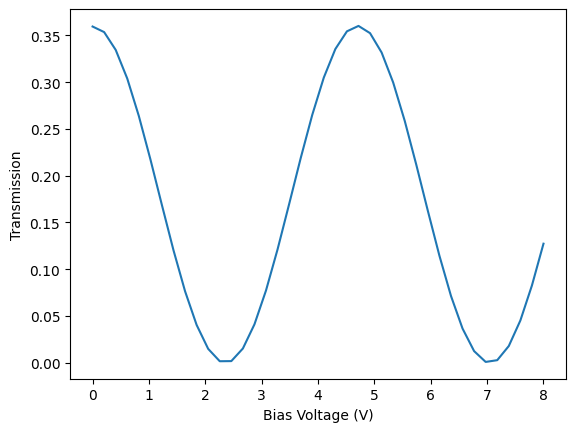

In [17]:
voltages = np.linspace(0, 8, 40)
transmission = []
for voltage in voltages:
    eo_model_plus.update(n_complex=index(voltage))
    eo_model_minus.update(n_complex=index(-voltage))
    s = optical_circuit.s_matrix(pf.C_0 / wavelengths, show_progress=False)
    transmission.append(np.abs(s["P0@0", "P1@0"][0] ** 2))

plt.plot(voltages, transmission)
plt.xlabel("Bias Voltage (V)")
_ = plt.ylabel("Transmission")

### Loss Calculation

We can estimate the total fiber-to-fiber insertion loss of the device. First, we calculate the on-chip optical loss by taking the maximum transmission value obtained from the previous voltage sweep simulation (`np.max(transmission)`) and converting it to decibels (dB). To estimate the total fiber-to-fiber loss, we add an approximate 8 dB loss to account for coupling between the optical fibers and the chip facets (4 dB per facet), as suggested by [1]. The final estimated loss is then printed. This calculated value shows excellent agreement with the total measured fiber-to-fiber insertion loss reported in [1], which is typically 12-14 dB.

In [18]:
# Calculate the estimated on-chip insertion loss in dB from the maximum transmission.
# Add 8 dB to account for estimated fiber-to-chip coupling loss (4 dB per facet).
loss_dB = -10 * np.log10(np.max(transmission)) + 8
print(f"Loss: {loss_dB:.1f} dB")

Loss: 12.4 dB
